# RealNVP flows from scratch

__Objective:__ build and train a simple RealNVP flow model from scratch.

__Source:__ D. Foster, [_Generative deep learning_](https://www.oreilly.com/library/view/generative-deep-learning/9781492041931/) (2nd ed.) (with notebooks [here](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition)).

**Setup:**
- We start from a vetor $z \in \mathbb{R}^D$ in latent space, which we sample from a multivariate standard normal distribution, so $p_Z \sim \mathcal{N}(0, I)$.
- We transform $z$ to the "real" data space $x \in \mathbb{R}^D$ via the RealNVP transformation so that $z \to x = x(z)$ is the **forward** transformation (this is opposite to what's done in the source, in which this is taken to be the inverse transformation, but for RealNVP's it doesn't really matter the forward and the inverse transformation are computationally equivalent).
- The RealNVP transformation is implemented by a stack of **coupling layers** with feature permutation operations (bijectors) in between.
- Following the RealNVP recipe, in each coupling layer the first $d$ dimensions (features) of $x$ are singled out and used to generate the corresponding dimensions of $z$ (an identity transformation) and to parametrize (via a neural network) an affine transformation for the last $(D - d)$ dimensions of $z$.
- Full transformation for a single coupling layer:
$$
\begin{array}{lll}
z_i &=& x_i\quad \forall x=i, \ldots, d\\
z_j &=& x_j\,\exp\left( s_j(x_1, \ldots, x_d) \right) + t_j(x_1, \ldots, x_d)\quad \forall j = d+1, \ldots, D
\end{array}
$$
where the vectors $s, t \in \mathbb{R}^{D-d}$ are the tensors outputted by the coupling layer and are functions of $x_1, \ldots, x_d$ given by a neural network.

In [1]:
import sys
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../modules/')

tfd = tfp.distributions

sns.set_theme()

%load_ext autoreload
%autoreload 2

2023-11-07 17:03:58.730603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Coupling layer

The coupling layer is responsible for taking the first $d$ dimensions (features) of the input and outputting a scale and a translation tensor (so two outputs) to be used to parametrize an affine transformation for the remaining $(D - d)$ dimensions of the input.

In [2]:
from real_nvp import CouplingLayer

In [3]:
n_masked_dims = 2
n_affine_dims = 3

test_cl = CouplingLayer(
    n_masked_dims=n_masked_dims,
    n_affine_dims=n_affine_dims,
    hidden_layers_dims=[32, 32]
)

s, t = test_cl(tf.random.normal(shape=(14, 5)))

## RealNVP bijector

Parametrize an affine (scale and then shift) tranformation with the output from the `CouplingLayer`.

In [4]:
from real_nvp import AffineBijector

In [5]:
# Generate simple test data.
test_data = tf.ones(shape=(4, 5)) * 2.4

# Instantiate an affine bijector parametrized by a
# coupling layer so that it works as a RealNVP bijector.
test_real_nvp_bij = AffineBijector(test_cl)

Test the forward and inverse transformations. In both cases the first `n_masked_dims` of the datapoints should be left unaltered.

In [6]:
test_real_nvp_bij.forward(test_data), test_real_nvp_bij.inverse(test_data)

(<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
 array([[2.4      , 2.4      , 2.6493387, 3.0801163, 3.4792519],
        [2.4      , 2.4      , 2.6493387, 3.0801163, 3.4792519],
        [2.4      , 2.4      , 2.6493387, 3.0801163, 3.4792519],
        [2.4      , 2.4      , 2.6493387, 3.080116 , 3.4792519]],
       dtype=float32)>,
 <tf.Tensor: shape=(4, 5), dtype=float32, numpy=
 array([[2.4      , 2.4      , 2.2119339, 1.8959775, 1.46423  ],
        [2.4      , 2.4      , 2.2119339, 1.8959775, 1.46423  ],
        [2.4      , 2.4      , 2.2119339, 1.8959775, 1.46423  ],
        [2.4      , 2.4      , 2.2119339, 1.8959775, 1.46423  ]],
       dtype=float32)>)

Check a "cycle condition": applying the forward and then the inverse transformation on some data (and vice versa) we should reobtain the starting tensors.

In [7]:
tf.norm(test_real_nvp_bij.inverse(test_real_nvp_bij.forward(test_data)) - test_data)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [8]:
tf.norm(test_real_nvp_bij.forward(test_real_nvp_bij.inverse(test_data)) - test_data)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

## RealNVP layer

The `RealNVP` layer object represents one RealNVP block inside a larger model. It's composed of 2 operations: a feature permutation followed by an affine transformation parametrized by a `CouplingLayer` object.

In [9]:
from real_nvp import RealNVPLayer

In [10]:
test_rnvp_layer = RealNVPLayer(
    n_masked_dims=2,
    n_affine_dims=3,
    hidden_layers_dims=[32, 32]
)

In [11]:
test_rnvp_layer(
    tf.constant([range(test_rnvp_layer.n_masked_dims + test_rnvp_layer.n_affine_dims)] * 4, dtype=tf.float32)
)

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[0.        , 3.        , 4.35048   , 0.06059462, 0.1730265 ],
       [0.        , 3.        , 4.35048   , 0.06059462, 0.1730265 ],
       [0.        , 3.        , 4.35048   , 0.06059462, 0.1730265 ],
       [0.        , 3.        , 4.35048   , 0.06059462, 0.1730265 ]],
      dtype=float32)>

In [12]:
test_rnvp_layer.count_params()

2502

## RealNVP model

In [13]:
from real_nvp import RealNVPModel

In [14]:
test_rnvp_model = RealNVPModel(
    n_masked_dims=2,
    n_affine_dims=3,
    n_real_nvp_blocks=3,
    hidden_layers_dims=[32, 32]
)

In [15]:
test_rnvp_model(test_data)

test_rnvp_model.summary()

Model: "real_nvp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 real_nvp_layer_1 (RealNVPL  multiple                  0 (unused)
 ayer)                                                           
                                                                 
 real_nvp_layer_2 (RealNVPL  multiple                  0 (unused)
 ayer)                                                           
                                                                 
 real_nvp_layer_3 (RealNVPL  multiple                  0 (unused)
 ayer)                                                           
                                                                 
Total params: 7506 (29.32 KB)
Trainable params: 7506 (29.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compute log probabilities with the base and the transformed distributions.

**Note:** the event shape of the distribution should be equal to the shape of one sample so that one sample corresponds to one value of log prob.

In [16]:
test_rnvp_model.base_distr, test_rnvp_model.transformed_distr

(<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[5] dtype=float32>,
 <tfp.distributions._TransformedDistribution 'chain_of_chain_of_affine_bij_of_permute_of_chain_of_affine_bij_of_permute_of_chain_of_affine_bij_of_permuteIndependentNormal' batch_shape=[] event_shape=[5] dtype=float32>)

In [17]:
test_rnvp_model.base_distr.log_prob(test_data), test_rnvp_model.transformed_distr.log_prob(test_data)

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-18.994694, -18.994694, -18.994694, -18.994694], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-59.402237, -59.402237, -59.402237, -59.402237], dtype=float32)>)

## Training

Generate data.

In [18]:
from sklearn.datasets import make_moons
from tensorflow.keras import backend as K
from keras_utilities import plot_history

In [19]:
data, labels_data = make_moons(n_samples=2500, noise=.06)

data = tf.constant(data, dtype=tf.float32)

In [20]:
rnvp_model = RealNVPModel(
    n_masked_dims=1,
    n_affine_dims=1,
    n_real_nvp_blocks=3,
    hidden_layers_dims=[32, 32]
)

Text(0.5, 1.0, 'Data')

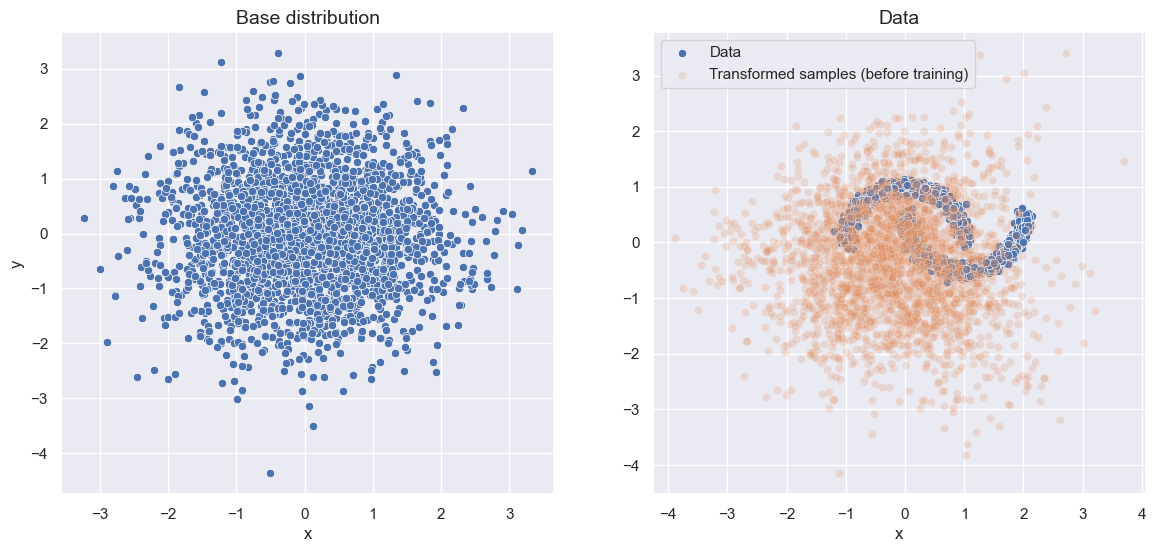

In [21]:
fig, axs = plt.subplots(figsize=(14, 6), nrows=1, ncols=2)

base_samples = rnvp_model.base_distr.sample(2500)

sns.scatterplot(
    x=base_samples[:, 0],
    y=base_samples[:, 1],
    ax=axs[0]
)

plt.sca(axs[0])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Base distribution', fontsize=14)

sns.scatterplot(
    x=data[:, 0],
    y=data[:, 1],
    ax=axs[1],
    label='Data'
)

transformed_samples = rnvp_model.transformed_distr.bijector.forward(base_samples)

sns.scatterplot(
    x=transformed_samples[:, 0],
    y=transformed_samples[:, 1],
    ax=axs[1],
    label='Transformed samples (before training)',
    alpha=.2
)

plt.sca(axs[1])
plt.xlabel('x')
plt.title('Data', fontsize=14)

Fit model to the data using a custom training step.

In [22]:
def nll(data, distr):
    """
    Negative log likelihood of data `data` w.r.t. the distribution
    `distr`, used as an objective function (loss) to minimize
    during training.
    """
    return - tf.reduce_mean(distr.log_prob(data))


@tf.function
def training_step(data, model, loss_fn, optimizer):
    """
    A single training step.
    """
    with tf.GradientTape() as tape:
        loss = nll(data, model.transformed_distr)
    
    grad = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(grad, model.trainable_variables))

    return loss

In [23]:
training_history = {
    'loss': [],
    'learning_rate': []
}

In [24]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[2500, 15000],
    values=[1e-2, 1e-3, 0.0005]
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [26]:
# K.set_value(optimizer.learning_rate, 0.0005)

Epoch: 0 | Loss: 0.8261527419090271 | Learning rate: 0.0010000000474974513
Epoch: 1 | Loss: 0.8185861110687256 | Learning rate: 0.0010000000474974513
Epoch: 2 | Loss: 0.8268715739250183 | Learning rate: 0.0010000000474974513
Epoch: 3 | Loss: 0.8191401362419128 | Learning rate: 0.0010000000474974513
Epoch: 4 | Loss: 0.8276835083961487 | Learning rate: 0.0010000000474974513
Epoch: 200 | Loss: 0.8305448293685913 | Learning rate: 0.0010000000474974513
Epoch: 400 | Loss: 0.8267335891723633 | Learning rate: 0.0010000000474974513
Epoch: 600 | Loss: 0.8266993165016174 | Learning rate: 0.0010000000474974513
Epoch: 800 | Loss: 0.8197864294052124 | Learning rate: 0.0010000000474974513
Epoch: 1000 | Loss: 0.8191386461257935 | Learning rate: 0.0010000000474974513
Epoch: 1200 | Loss: 0.8247753977775574 | Learning rate: 0.0010000000474974513
Epoch: 1400 | Loss: 0.8186577558517456 | Learning rate: 0.0010000000474974513
Epoch: 1600 | Loss: 0.8210828900337219 | Learning rate: 0.0010000000474974513
Epoch

Text(0.5, 1.0, 'Data')

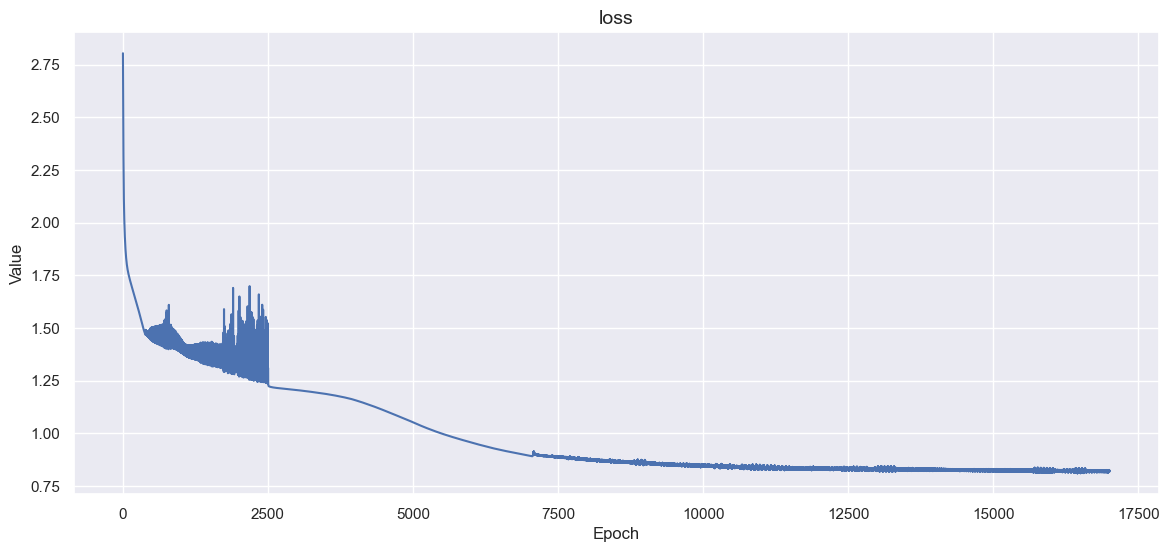

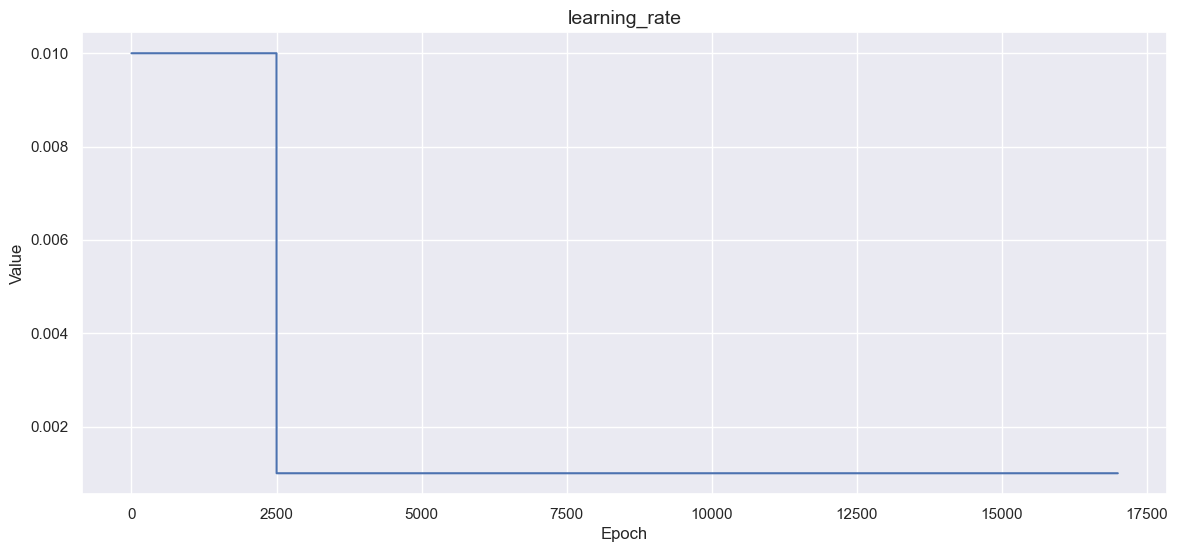

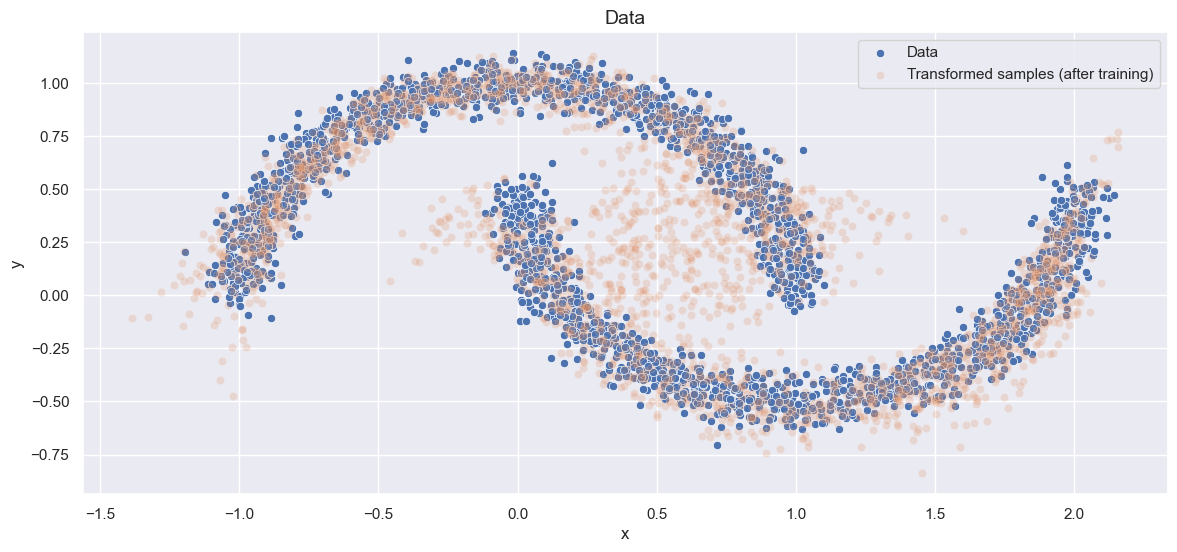

In [27]:
epochs = 17000

for epoch in range(epochs):
    training_history['loss'].append(training_step(data, rnvp_model, nll, optimizer).numpy())

    training_history['learning_rate'].append(optimizer.learning_rate.numpy())

    if (epoch < 5) or (epoch % 200 == 0):
        print(f'Epoch: {epoch} | Loss: {training_history["loss"][-1]} | Learning rate: {training_history["learning_rate"][-1]}')

plot_history(training_history)


# Plot data and samples from the transformed distribution.
fig = plt.figure(figsize=(14, 6))

transformed_samples = rnvp_model.transformed_distr.sample(2500)

sns.scatterplot(
    x=data[:, 0].numpy(),
    y=data[:, 1].numpy(),
    label='Data'
)

sns.scatterplot(
    x=transformed_samples[:, 0],
    y=transformed_samples[:, 1],
    label='Transformed samples (after training)',
    alpha=.2
)


plt.xlabel('x')
plt.ylabel('y')
plt.title('Data', fontsize=14)

In [90]:
# Save model.
# rnvp_model.save('../models/real_nvp_from_scratch_model.keras')

# To then load model.
# rnvp_model_loaded = tf.keras.models.load_model(
#     '../models/real_nvp_from_scratch_model.keras',
#     safe_mode=False
# )

Plot the data and random samples from the transformed distribution.

Text(0.5, 1.0, 'Data')

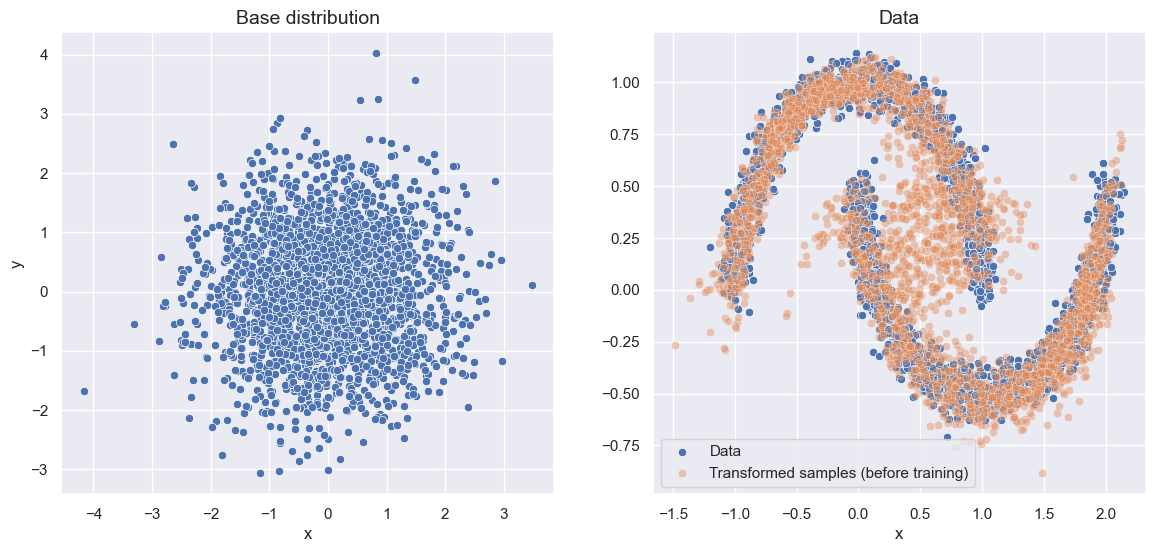

In [30]:
fig, axs = plt.subplots(figsize=(14, 6), nrows=1, ncols=2)

base_samples = rnvp_model.base_distr.sample(2500)

sns.scatterplot(
    x=base_samples[:, 0],
    y=base_samples[:, 1],
    ax=axs[0]
)

plt.sca(axs[0])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Base distribution', fontsize=14)

sns.scatterplot(
    x=data[:, 0],
    y=data[:, 1],
    ax=axs[1],
    label='Data'
)

transformed_samples = rnvp_model.transformed_distr.bijector.forward(base_samples)

sns.scatterplot(
    x=transformed_samples[:, 0],
    y=transformed_samples[:, 1],
    ax=axs[1],
    label='Transformed samples (before training)',
    alpha=.4
)

plt.sca(axs[1])
plt.xlabel('x')
plt.title('Data', fontsize=14)

### Trajectories in the transformed space

Let's take a continuous curve in the original space ($z$) and see how it's mapped to the transformed space ($x$).

**Observations:**
- The "speed" of the trajectory is not constant - the trajectory has constant speed in z-space (at each step the distance between two subsequent points is constant) but not in x-space. This reflects in the fact that in some regions in x-space, the trajectory to reach nearby points can start zigzagging quickly, in a seemingly non-continuous way. The transformation should be countinuous nevertheless, soeverything should become a smooth curve, although maybe dense, as the number of time steps increases keeping the initial and final points fixed.
- The above phenomenon can be seen by selecting the starting and final points in z-space to be the counterimages of points $x_i = (2., 0.25)$ and $x_f = (0.1, 0.0)$ in z-space and using 200 time steps and the model that can be loaded above. Everything is regular with these points, but as soon as we increase the y coordinate of $x_f$ the trajectory in x-space start zigzagging.

Text(0.5, 1.0, 'Data')

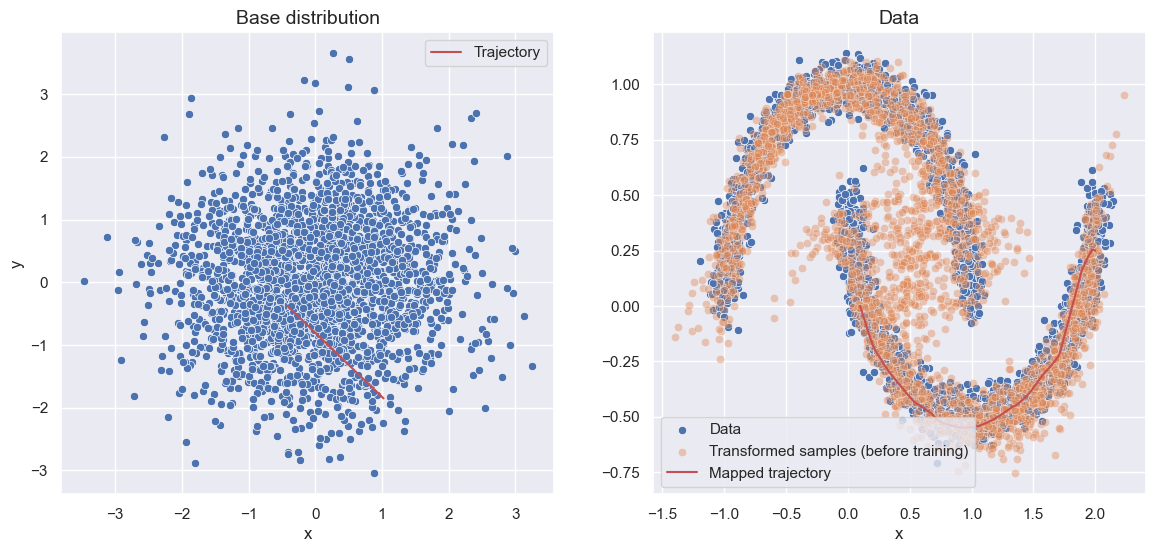

In [101]:
# Extrema of the trajectory in z-space.
# z_extr = tf.constant([[-2., -1.], [1.5, -.5]])
x_extr = tf.constant([[2., 0.25], [0.1, 0.]])

z_extr = rnvp_model.transformed_distr.bijector.inverse(x_extr)

# Trajectory in z-space.
z_traj = (z_extr[1, :] - z_extr[0, :]) * tf.linspace(0., 1., 200)[:, tf.newaxis] + z_extr[0, :]

# Trajectory in x-space (i.e. image of the trajectory in z-space
# via the model).
x_traj = rnvp_model(z_traj)


# Plot the samples and the curves.
fig, axs = plt.subplots(figsize=(14, 6), nrows=1, ncols=2)

base_samples = rnvp_model.base_distr.sample(2500)

sns.scatterplot(
    x=base_samples[:, 0],
    y=base_samples[:, 1],
    ax=axs[0]
)

sns.lineplot(
    x=z_traj[:, 0],
    y=z_traj[:, 1],
    ax=axs[0],
    color='r',
    label='Trajectory'
)

plt.sca(axs[0])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Base distribution', fontsize=14)

sns.scatterplot(
    x=data[:, 0],
    y=data[:, 1],
    ax=axs[1],
    label='Data'
)

transformed_samples = rnvp_model.transformed_distr.bijector.forward(base_samples)

sns.scatterplot(
    x=transformed_samples[:, 0],
    y=transformed_samples[:, 1],
    ax=axs[1],
    label='Transformed samples (before training)',
    alpha=.4
)

sns.lineplot(
    x=x_traj[:, 0],
    y=x_traj[:, 1],
    ax=axs[1],
    color='r',
    label='Mapped trajectory'
)

plt.sca(axs[1])
plt.xlabel('x')
plt.title('Data', fontsize=14)